## Spatial regression analysis for testing associations between gene expression and mechanical properties

Note: this notebook uses R.

- Use gSEM model to look for associations between gene expression and cellular mechanics while taking spatial confounding into account
- Do further analysis of genes identified as statistically significant
- Compare spatial regression to simple linear regression models

In [1]:
dataset <- 'dataset3'

### Preprocessing

#### Library imports

In [2]:
suppressWarnings(suppressMessages(library(sp)))
suppressWarnings(suppressMessages(library(mgcv)))
suppressWarnings(suppressMessages(library(dplyr)))
suppressWarnings(suppressMessages(library(progress)))
suppressWarnings(suppressMessages(library(parallel)))
suppressWarnings(suppressMessages(library(ggplot2)))
suppressWarnings(suppressMessages(library(ggpubr)))
suppressWarnings(suppressMessages(library(doParallel)))
suppressWarnings(suppressMessages(library(EnhancedVolcano)))
suppressWarnings(suppressMessages(library(clusterProfiler)))
suppressWarnings(suppressMessages(library(org.Mm.eg.db)))
suppressWarnings(suppressMessages(library(stringr)))
suppressWarnings(suppressMessages(library(BuenColors)))
suppressWarnings(suppressMessages(library(grid)))
source("helper_functions.R")

#### Define functions for gSEM regression

In [3]:
tensionmap_res <- read.table(paste0('../reproduce_data/', dataset, '/tensionmap_res.csv', collapse=''), sep=',', header = T, row.names = 1)
gex_res <- read.table(paste0('../reproduce_data/', dataset, '/gex_res.csv', collapse=''), sep=',', header = T, row.names = 1)

In [4]:
tensionmap_res[['stresstensor_magnitude']] <- tensionmap_res[['stresstensor_eigval1']] + tensionmap_res[['stresstensor_eigval2']]

### Perform spatial regression

Note: this step is computationally intensive as it takes ~10s to construct a model for each gene (tested on M1 Macbook Pro). For demonstration purposes we only do regression on a random subset of 100 genes.

In [5]:
# Find genes expressed in >50% of cells
expressed_genes <- rownames(gex_res)[apply(gex_res, 1, function(x){return(sum(x>0)/length(x))}) > 0.5]

To perform analysis on the full dataset, comment out this line and replace all instances of `expressed_genes_subset` with `expressed_genes`

In [6]:
# Randomly sample from expressed genes
set.seed(11234)

# Change number in argument 2 to sample fewer or more genes
expressed_genes_subset <- sample(expressed_genes, 100, replace=F)

In [7]:
# Note: change number of cores to match local system specifications
gsem_reg_res_smooth <- parallel_gsem_regression(expressed_genes_subset, tensionmap_res, gex_res, model_fx = T, ncores = 8)

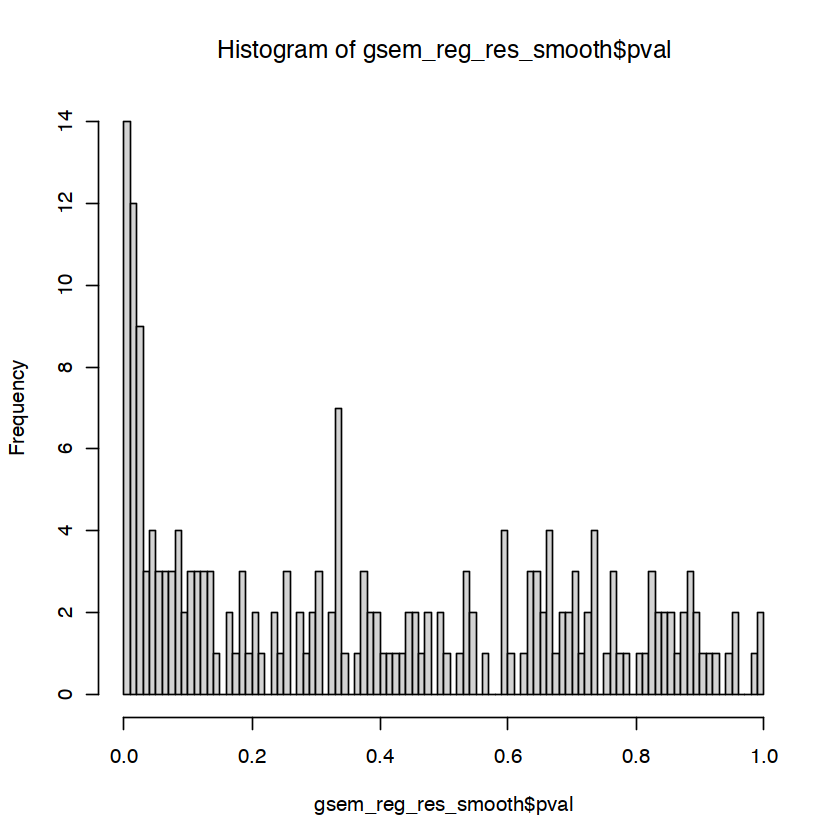

In [8]:
# Check distribution of p-values
hist(gsem_reg_res_smooth$pval, breaks=100)

In [9]:
gsem_reg_res_smooth$padj <- p.adjust(gsem_reg_res_smooth$pval, method = 'BH')

### Further analysis of results

#### Generate volcano plots
Note: for this analysis the adjusted p-value threshold has been set to 0.1 for illustrative purposes. The threshold value used for the full analysis is 0.05.

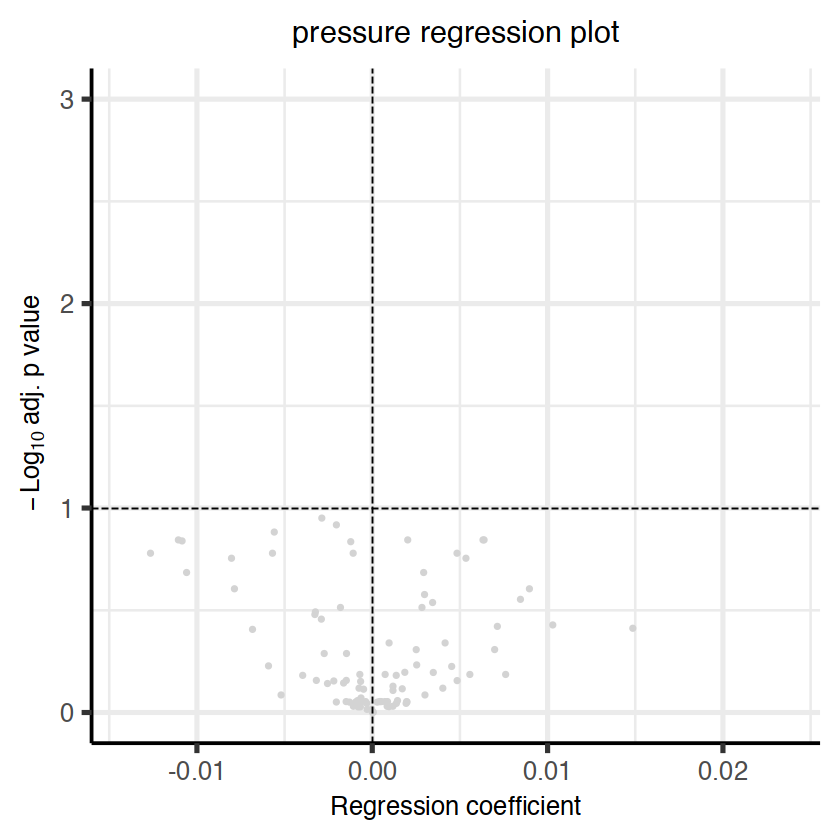

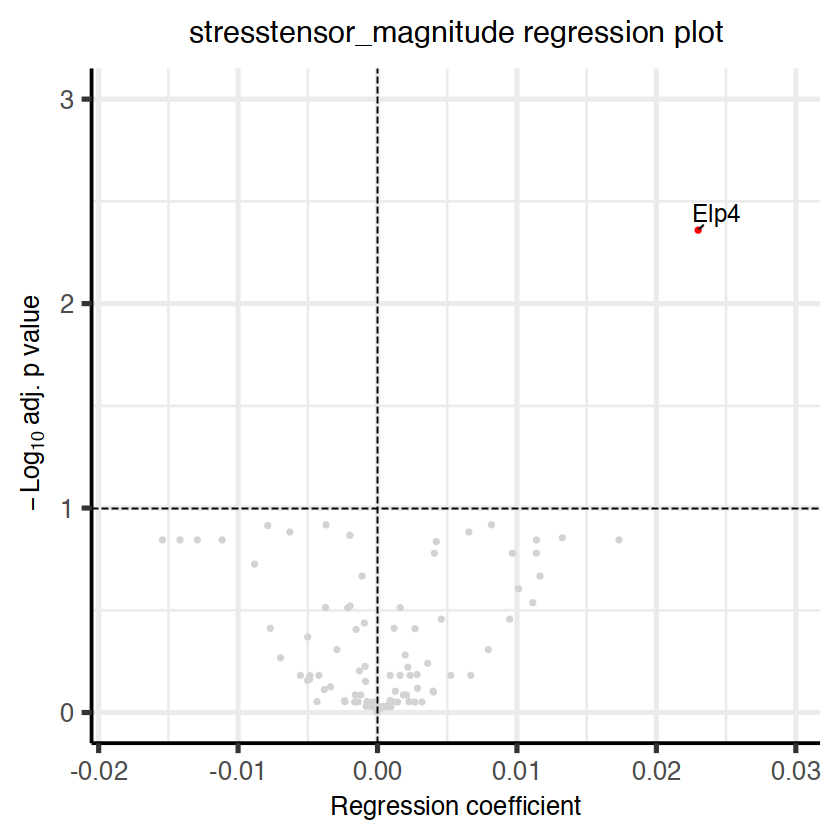

In [10]:
for (curr_metric in c('pressure', 'stresstensor_magnitude')) {
  metric_reg_res <- dplyr::filter(gsem_reg_res_smooth, metric==curr_metric)
  metric_reg_res <- dplyr::mutate(metric_reg_res, log_padj=-log10(padj))
  
  points_cols <- ifelse(metric_reg_res$padj < 0.1, 'red','lightgrey')
  names(points_cols) <- metric_reg_res$gene
  
  volcano_plot <- EnhancedVolcano(metric_reg_res,
                                  lab = metric_reg_res$gene,
                                  drawConnectors = TRUE,
                                  x = 'beta',
                                  y = 'padj',
                                  pointSize = 1,
                                  subtitle = NULL,
                                  FCcutoff = 0,
                                  xlim = quantile(metric_reg_res$beta, c(0.001, 0.999)),
                                  ylim = c(0, 3),
                                  pCutoff = 0.1,
                                  caption = NULL,
                                  xlab = c('Regression coefficient'),
                                  ylab =  bquote(~-Log[10] ~ 'adj. p value'),
                                  axisLabSize = 15,
                                  colCustom = points_cols,
                                  arrowheads = FALSE,
                                  colAlpha = 1,
                                  legendPosition = 'none',
                                  title = paste(curr_metric,'regression plot',sep=' ')) +
    theme(plot.title = element_text(hjust = 0.5))
  print(volcano_plot)
}


#### Plot spatially regressed residuals for a single gene and mechanical property

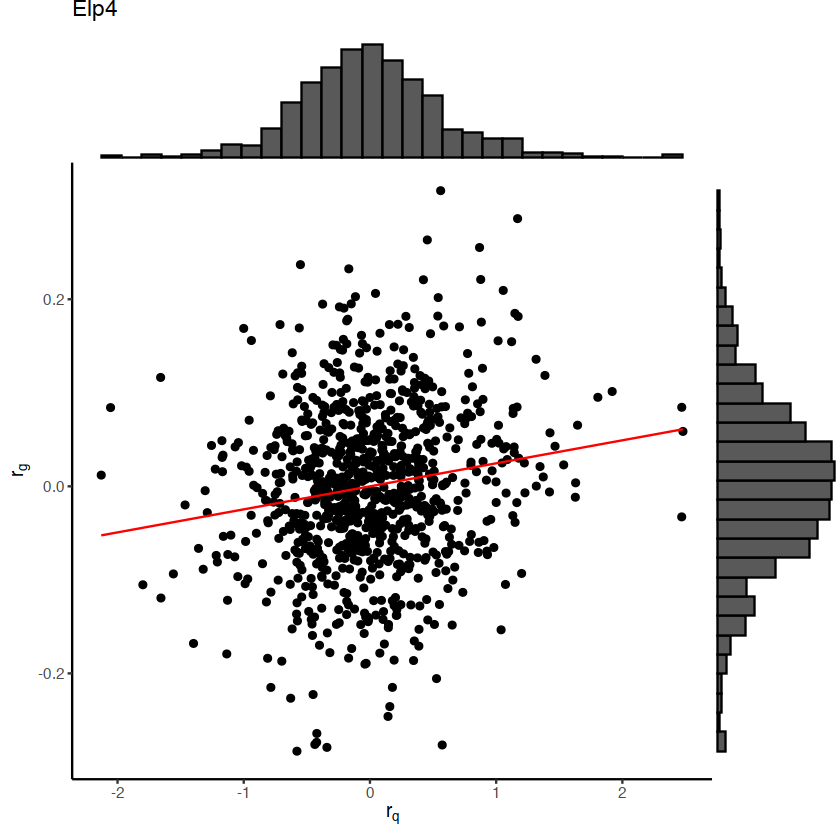

In [11]:
metric_use <- 'pressure'
gene <- dplyr::arrange(gsem_reg_res_smooth[gsem_reg_res_smooth$metric == metric_use, ], padj)[1,'gene']

gsem_reg_res_singlegene <- do_gsem_regression(gene, metric_use, tensionmap_res, gex_res)
plot_df <- data.frame(r_X = gsem_reg_res_singlegene[[2]], r_Y = gsem_reg_res_singlegene[[3]], fitted = gsem_reg_res_singlegene[[1]]$fitted.values)
p <- ggplot(plot_df) +
  geom_point(aes(x=r_X, y=r_Y)) +
  geom_line(aes(x=r_X, y=fitted), color='red') +
  ggtitle(gene) +
  theme_classic() +
  xlab(bquote(r[q])) +
  ylab(bquote(r[g]))
p <- ggExtra::ggMarginal(p, type = "histogram")
p

#### Do GO overrepresentation analysis
Note: code used here is the same as for the full analysis but results will differ as we only do regression for a subset of genes

In [12]:
# GO analysis
p_go_res <- enrichGO(gene      = gsem_reg_res_smooth[(gsem_reg_res_smooth$padj < 0.1) & (gsem_reg_res_smooth$metric == 'pressure'), 'gene'],
                     universe     = expressed_genes_subset,
                     OrgDb        = org.Mm.eg.db,
                     ont          = "BP",
                     keyType      = "SYMBOL", 
                     minGSSize    = 10,
                     maxGSSize    = 500,
                     pvalueCutoff = 1)

sm_go_res <- enrichGO(gene      = gsem_reg_res_smooth[(gsem_reg_res_smooth$padj < 0.1) & (gsem_reg_res_smooth$metric == 'stresstensor_magnitude'), 'gene'],
                      universe     = expressed_genes_subset,
                      OrgDb        = org.Mm.eg.db,
                      ont          = "BP",
                      keyType      = "SYMBOL", 
                      minGSSize    = 10,
                      maxGSSize    = 500,
                      pvalueCutoff = 1)


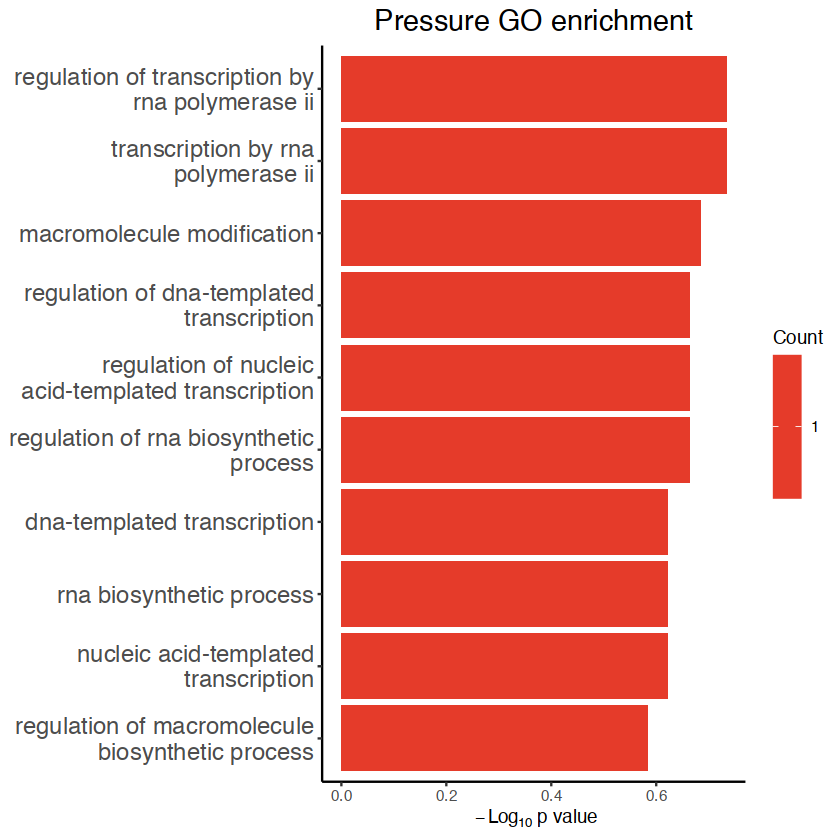

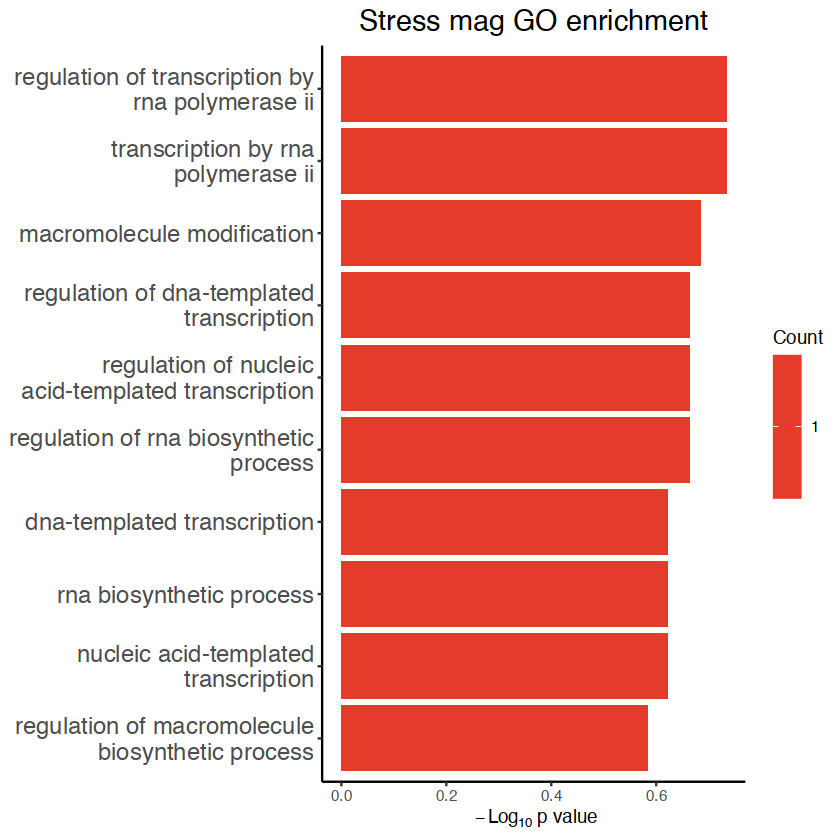

In [13]:
makebarplot(p_go_res@result, title = 'Pressure GO enrichment', 10)
makebarplot(sm_go_res@result, title = 'Stress mag GO enrichment', 10)

### Compare spatial regression to linear regression model

#### Define functions for parallel linear regression

In [14]:
lin_reg_res <- parallel_linear_regression(expressed_genes_subset, tensionmap_res, gex_res, ncores = 8)

In [15]:
lin_reg_res %>% head()

,gene,metric,beta,pval,stat
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
X,Arpin,pressure,-1.325786e-03,0.5863487,-0.54432760
X1,Arpin,stresstensor_magnitude,5.307173e-04,0.8094754,0.24117256
X2,Exoc3,pressure,-6.345301e-03,0.1871859,-1.31993772
X11,Exoc3,stresstensor_magnitude,-5.539573e-03,0.2024521,-1.27551114
X3,Pik3r3,pressure,-4.269925e-04,0.7662658,-0.29735128
X12,Pik3r3,stresstensor_magnitude,3.170205e-05,0.9805093,0.02443712


#### Compare coefficients for spatial vs linear regression

In [16]:
comp_df <- merge(gsem_reg_res_smooth, lin_reg_res, by.x=c('gene','metric'), by.y=c('gene','metric'), suffixes=c('_gsem','_linreg'))

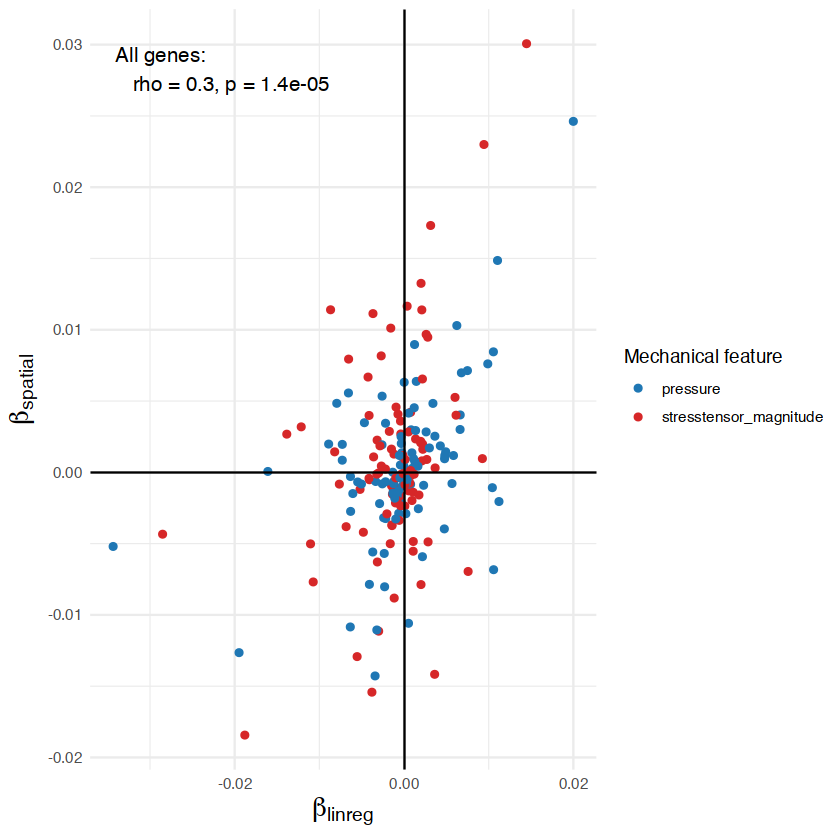

In [17]:
all_cor <- cor.test(comp_df$beta_gsem, comp_df$beta_linreg, method = 'spearman')
grob <- grobTree(textGrob(paste0("All genes:\n   rho = ",signif(all_cor$estimate,2),", p = ",signif(all_cor$p.value,2)), 
                            hjust=0, vjust=1, x=0.05,  y=0.95,
                            gp=gpar(col="black", fontface="italic", fontsize=12)))

ggplot() +
    geom_point(data=comp_df, aes(x=beta_linreg, y=beta_gsem, color=metric)) +
    geom_vline(xintercept = 0) +
    geom_hline(yintercept = 0) + 
    theme_minimal() +
    annotation_custom(grob) +
    ylab(bquote(beta[spatial])) +
    xlab(bquote(beta[linreg])) +
    scale_color_manual(values=jdb_palette('corona'),name = "Mechanical feature") +
    scale_alpha_continuous(name = bquote(~-Log[10] ~ 'p-value')) +
    theme(axis.title=element_text(size=16))

#### Environment information:

In [18]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] en_GB.UTF-8/en_GB.UTF-8/en_GB.UTF-8/C/en_GB.UTF-8/en_GB.UTF-8

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] BuenColors_0.5.6       MASS_7.3-58.3          stringr_1.5.0         
 [4] org.Mm.eg.db_3.16.0    AnnotationDbi_1.60.2   IRanges_2.32.0        
 [7] S4Vectors_0.36.2       Biobase_2.58.0         BiocGenerics_0.44.0   
[10] clusterProfiler_4.6.2  EnhancedVolcano_1.16.0 ggrepel_0.9.3         
[13] doParallel_1.0.17      iterators_1.0.14       foreach_1.5.2         
[16] ggpubr_0.6.0           ggplot2_3.4.2          progress_1.2.2        
[19] dplyr_1.1.